# A journey to Data Scientist

__Students:__

- KLUTSE Raymond: <span style="color:blue">raymond.klutse@imt-atlantique.net</span>   
- MISHRA Rudresh: <span style="color:blue">rudresh.mishra@imt-atlantique.net</span>   
- QU Runlu: <span style="color:blue">runlu.qu@imt-atlantique.net</span>    
- TORRES Jhonatan: <span style="color:blue">jhonatan-leonardo.torres-sanchez@imt-atlantique.net</span>   

### Libraries

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sqlite3
import re
import os

from tqdm import tqdm

### Extracting the data to csv files

In [2]:
con = sqlite3.connect('./data/yelpHotelData.db') # Name of the container file of our database.
cursor = con.cursor()
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
table_names = [elem[0] for elem in (cursor.fetchall())]
print(table_names) # Print the name of the tables inside the database.

['review', 'sqlite_stat1', 'sqlite_stat2', 'reviewer', 'hotel']


In [3]:
table_names = ['review', 'reviewer', 'hotel'] # Tables to safe as csv files.
for table_name in table_names:
    if not os.path.isfile(table_name + '.csv'): # If the file does not exist, create it.
        table = pd.read_sql('SELECT * FROM ' + table_name, con)
        table.to_csv(table_name + '.csv', index_label=False) # Save the tables csv files.

In [4]:
def date2date1(date):
    # Function used to turn the date to format MM/DD/AAAA from column date in review.
    out = ''
    for elem in re.split(r'/', date):
        elem = re.findall(r'\d+', elem)[-1]
        if len(elem)==1:
            out += '0'
        out += elem + '/'
    return out[:-1]

def date2date2(date):
    # Function used to turn the date to format MM/DD/AAAA from column date in reviewer.
    m = {'january': '01', 'february': '02', 'march': '03',
         'april': '04', 'may': '05', 'june': '06',
         'july': '07', 'august': '08', 'september': '09',
         'october': '10', 'november': '11', 'december': '12'}
    split = re.split(r' ', date.lower())
    return m[split[-2]] + '/01/' + split[-1]

def get_amount_of_words(text): 
    # Return the amount of words in a review.
    if text is np.nan: return 0 # If empty return 0.
    return len(re.split(r' ', text))



### Loading the data into DataFrames

In [5]:
# Original format of reviews.
df_review = pd.read_csv('review.csv')
df_review.loc[0]

date                                                      6/8/2011
reviewID                                              MyNjnxzZVTPq
reviewerID                                  IFTr6_6NI4CgCVavIL9k5g
reviewContent    Let me begin by saying that there are two kind...
rating                                                           5
usefulCount                                                     18
coolCount                                                       11
funnyCount                                                      28
flagged                                                          N
hotelID                                     tQfLGoolUMu2J0igcWcoZg
Name: 0, dtype: object

In [6]:
# Original format of reviewers.
df_reviewer = pd.read_csv('reviewer.csv')
df_reviewer.loc[0]

reviewerID         yevHGEUQQmnVlBXIrJ885A
name                             Kevin T.
location                   Oconomowoc, WI
yelpJoinDate                     May 2011
friendCount                             4
reviewCount                            86
firstCount                              3
usefulCount                           129
coolCount                              47
funnyCount                             31
complimentCount                        12
tipCount                                0
fanCount                                1
Name: 0, dtype: object

In [7]:
# Original format of hotels.
df_hotel = pd.read_csv('hotel.csv')
df_hotel.loc[0]

hotelID                                          pSLh_XyV_3QS1hNsBOGHiQ
name                                                    Old Chicago Inn
location                       Old Chicago Inn - Lakeview - Chicago, IL
reviewCount                                                           1
rating                                                                3
categories            Event Planning & Services, Hotels, Hotels & Tr...
address               3222 N Sheffield Ave (between Belmont Ave & Sc...
AcceptsCreditCards                                                  Yes
PriceRange                                                           $$
WiFi                                                               Free
webSite                                    http://www.oldchicagoinn.com
phoneNumber                                              (773) 245-0423
filReviewCount                                                        5
Name: 0, dtype: object

### Data cleaning

In [8]:
def validate_reviewCount(df_i, df_g, ref, bins=100, ylabel='Amount'):
    # Function used to validate if the data specified for reviewers and hotels
    # as reviewCount represents what is found in the reviews table.
    # It plots the histogram of the difference between expected and obtained values.
    col_i = df_i.columns[0] # Takes the first column name.
    col_g = 'reviewCount' # Column name that represents the total amount of reviews per reviewer or hotel.
    df_1 = df_i[[ref, col_i]].groupby(ref).count() # Get the available amount of reviews per reviewer or hotel.
#     print(df_1.head(10))
    df_2 = pd.merge(df_1, df_g[[ref, col_g]], on=ref, how='inner') # Merge the 2 dataframes.
    difference = df_2[col_g].values - df_2[col_i].values
    print(difference)
    plt.hist(difference, bins=bins); plt.xlabel('Difference'); plt.ylabel(ylabel)
    plt.title('Histogram of the difference between expected and encountered reviews'); plt.grid() # Plot histogram.

[ 0 -7  0 ...  6 -2  0]


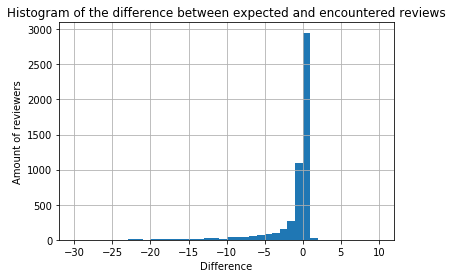

In [9]:
# Compare the 'reviewCount' column in the given dataset to what we have exactly in the dataset
# not too much difference, maybe there are some missing reviews which are not taken.
validate_reviewCount(df_review, df_reviewer, 'reviewerID', bins=np.linspace(-30, 10, 41), ylabel='Amount of reviewers')

[  1  12 122 ...   6  13   6]


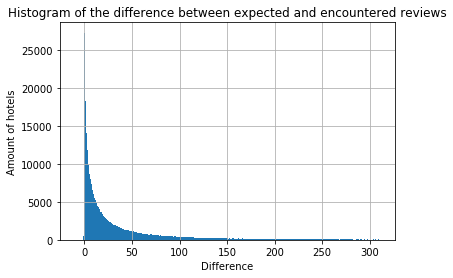

In [10]:
# Amount of reviews for each hotel compared with what is given by the original data, "reviewCount" in hotel's table.
validate_reviewCount(df_review, df_hotel, 'hotelID', bins=np.linspace(-10,310,321), ylabel='Amount of hotels')

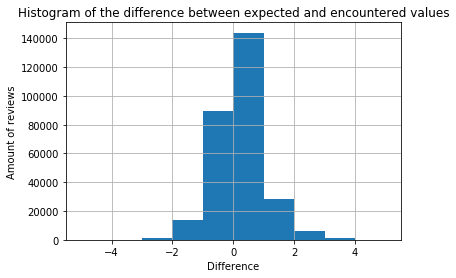

In [11]:
df_aux = df_review[['hotelID','rating']].groupby(['hotelID'])['rating'].mean().reset_index(name='calculated_rating')
# print(df_aux)
df_hotel = pd.merge(df_hotel, df_aux[['hotelID','calculated_rating']], on='hotelID', how='inner')
# print(df_hotel['rating']-df_hotel['calculated_rating'])
plt.hist(df_hotel['rating']-df_hotel['calculated_rating'], bins=np.linspace(-5, 5, 11)); plt.xlabel('Difference')
plt.ylabel('Amount of reviews'); plt.title('Histogram of the difference between expected and encountered values'); plt.grid()

In [12]:
df_hotel

,hotelID,name,location,reviewCount,rating,categories,address,AcceptsCreditCards,PriceRange,WiFi,webSite,phoneNumber,filReviewCount,calculated_rating
0,pSLh_XyV_3QS1hNsBOGHiQ,Old Chicago Inn,"Old Chicago Inn - Lakeview - Chicago, IL",1,3.0,"Event Planning & Services, Hotels, Hotels & Tr...",3222 N Sheffield Ave (between Belmont Ave & Sc...,Yes,$$,Free,http://www.oldchicagoinn.com,(773) 245-0423,5,2.600000
1,tQfLGoolUMu2J0igcWcoZg,Tokyo Hotel,"Tokyo Hotel - Near North Side - Chicago, IL",6,3.0,"Event Planning & Services, Hotels, Hotels & Tr...","19 E Ohio St Chicago, IL 60611 Neighborhood: N...",No,$,No,http://tokyohotels.webs.com/,(312) 787-4900,5,3.000000
2,33Xc1Bk_gkSY5xb2doQ7Ng,The Tremont Chicago Hotel at Magnificent Mile,The Tremont Chicago Hotel at Magnificent Mile ...,44,3.0,"Event Planning & Services, Hotels, Hotels & Tr...",100 East Chestnut (between Ernst Ct & Michigan...,Yes,$$,Free,http://www.tremontchicago.com,(312) 751-1900,5,2.750000
3,2nnXespKBBNtDQTtrumNFg,Inn At Lincoln Park,"Inn At Lincoln Park - Lincoln Park - Chicago, IL",20,2.0,"Event Planning & Services, Hotels, Hotels & Tr...",601 W Diversey Pkwy (between Broadway St & Cam...,Yes,$$$,Free,NaN,(773) 348-2810,5,2.071429
4,SNuJYJewLhunxlhEezo15w,Carleton Hotel,"Carleton Hotel - Oak Park, IL",31,4.0,"Event Planning & Services, Hotels, Hotels & Tr...",1110 Pleasant St (between Maple Ave & Marion S...,Yes,$$,Free,http://www.carletonhotel.com/,(708) 848-5000,5,4.150000
5,XZEBxlz9ZoP76CrYvEsL1A,Holiday Inn Express Hotel Chicago - Magnificen...,Holiday Inn Express Hotel Chicago - Magnificen...,19,3.5,"Event Planning & Services, Hotels, Hotels & Tr...",640 N Wabash Ave (between Ontario St & Erie St...,Yes,$$,Free,http://www.holidayinnexpress.com,(312) 787-4030,5,3.607143
6,FfG-PPZCz1sB4SKZoqsZkQ,The Whitehall Hotel,The Whitehall Hotel - Near North Side - Chicag...,58,3.5,"Event Planning & Services, Hotels, Hotels & Tr...",105 E Delaware Pl (between Ernst Ct & Huguelet...,Yes,$$,Paid,http://www.thewhitehallhotel.com/?…,(312) 944-6300,6,3.390244
7,yiXTDN-dfNq3NKXZPKgsaw,Hilton Suites Chicago,Hilton Suites Chicago - Near North Side - Chic...,34,4.0,"Event Planning & Services, Hotels, Hotels & Tr...",198 E Delaware Pl (between Michigan Ave & Sene...,Yes,$$,Paid,http://www.chicagomagnificentmile.…,(312) 664-1100,5,3.680000
8,SEyUJ4t_8K4fD0ZIQnbmrA,Gold Coast Chicago Hotel,Gold Coast Chicago Hotel - Near North Side - C...,46,3.5,"Event Planning & Services, Hotels, Hotels & Tr...",1244 N. Dearborn Pkwy (between Division St & G...,Yes,$$,Free,http://www.goldcoastchicagohotel.c…,(312) 787-4980,5,3.691176
9,qgpP1FOFrlssColqP2u-xA,Holiday Inn Hotel & Suites Chicago-Downtown,Holiday Inn Hotel & Suites Chicago-Downtown - ...,11,3.0,"Event Planning & Services, Hotels, Hotels & Tr...","506 West Harrison St (at Clinton St) Chicago, ...",Yes,$$,Free,http://www.holidayinn.com,(312) 957-9100,5,2.619048


In [13]:
df_reviewer = df_reviewer[['reviewerID', 'location', 'yelpJoinDate']]
df_reviewer.loc[0]

reviewerID      yevHGEUQQmnVlBXIrJ885A
location                Oconomowoc, WI
yelpJoinDate                  May 2011
Name: 0, dtype: object

In [14]:
df_hotel = df_hotel[['hotelID','location']]
df_hotel.loc[0]

hotelID                       pSLh_XyV_3QS1hNsBOGHiQ
location    Old Chicago Inn - Lakeview - Chicago, IL
Name: 0, dtype: object

### Data transformation

In [15]:
weekDays = ('Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday')
df_review['date'] = df_review['date'].apply(date2date1).astype('datetime64')
df_review['weekDay'] = df_review['date'].apply(lambda x: weekDays[x.weekday()])
df_review['flagged'] = df_review['flagged'].apply(lambda x: x in ['Y','YR'])
df_review['wordsCount'] = df_review['reviewContent'].apply(get_amount_of_words)
df_review.to_csv('new_review.csv')
df_review.loc[0]

date                                           2011-06-08 00:00:00
reviewID                                              MyNjnxzZVTPq
reviewerID                                  IFTr6_6NI4CgCVavIL9k5g
reviewContent    Let me begin by saying that there are two kind...
rating                                                           5
usefulCount                                                     18
coolCount                                                       11
funnyCount                                                      28
flagged                                                      False
hotelID                                     tQfLGoolUMu2J0igcWcoZg
weekDay                                                  Wednesday
wordsCount                                                     419
Name: 0, dtype: object

In [16]:
def get_arrays(df_i, df_g, ref):
    # This function returns a condense dataframe with arrays that 
    # summarize the behavior of a reviewer or hotel.
    df = pd.DataFrame(columns=['gap_times', 'ratings', 'flags']) # Output columns.
    df_1 = df_i[['date', 'rating', 'flagged', ref]] # Columns to evaluate.
    for i in tqdm(df_g[ref]): 
        df_2 = df_1[df_1[ref]==i] # Filter reviews of interest.
        df_2 = df_2.sort_values(by=['date']) # Sort dataframe per dates.
        date_values = np.int_(np.diff(df_2['date'].values)/np.timedelta64(1, 'D')) # Get time gaps between reviews.
        rating_values = np.int_(df_2['rating'].values) # Get rating values.
        flagged_values = np.array([i for i in df_2['flagged'].values]) # Get flags.
        df.loc[i] = [date_values, rating_values, flagged_values] # Add row to the final dataset.
    return df 

In [17]:
df_reviewer['yelpJoinDate'] = df_reviewer['yelpJoinDate'].apply(date2date2).astype('datetime64')
df_aux = get_arrays(df_review, df_reviewer, 'reviewerID')


100%|██████████| 5123/5123 [11:14<00:00,  7.59it/s]  


In [18]:
df_aux

,gap_times,ratings,flags
yevHGEUQQmnVlBXIrJ885A,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...","[4, 5, 1, 2, 4, 2, 4, 3, 3, 4, 4, 1, 1, 5, 4, ...","[False, False, False, False, False, False, Fal..."
yoB_PYQHjnPjh78ATA0Jgw,"[0, 0, 105, 0, 0, 0, 0, 0, 0, 0, 0, 28, 0, 0, ...","[5, 5, 4, 5, 4, 1, 4, 4, 1, 4, 5, 4, 4, 5, 3, ...","[False, False, False, False, True, False, Fals..."
XrFCag4AMW5qta9QXokWPA,"[0, 0, 0, 0, 0, 0, 218, 0, 0, 0, 0, 0, 0, 0, 0...","[2, 3, 5, 5, 4, 4, 4, 4, 4, 5, 5, 2, 5, 5, 5, ...","[False, False, False, False, True, True, True,..."
y5ptsWmvGEAftOQaiFhBcg,"[0, 0, 0, 0, 1, 0, 0, 0, 1, 4, 1, 0, 0, 2, 0, ...","[5, 1, 5, 4, 1, 5, 5, 1, 4, 4, 4, 4, 5, 5, 1, ...","[False, False, False, False, False, True, Fals..."
uUVZJm9yxNl5FBsXbt4WBg,"[0, 0, 0, 2, 2, 0, 68, 269, 13, 0, 6, 11, 3, 1...","[1, 4, 4, 5, 1, 4, 4, 5, 3, 4, 4, 4, 4, 4, 4, ...","[True, True, True, False, True, True, False, T..."
ZCRY4GLLTli8tZRPi1P7Cw,"[0, 0, 0, 0, 17, 4, 20, 0, 0, 39, 1, 48, 41, 2...","[4, 3, 5, 2, 1, 5, 5, 1, 3, 4, 4, 3, 3, 5, 2, ...","[False, True, True, False, True, True, True, T..."
uOFIY6vBBp7O6un8CLggTw,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 3, 0, 0, ...","[1, 2, 5, 3, 1, 1, 3, 4, 4, 1, 4, 5, 5, 4, 4, ...","[True, True, False, False, False, False, False..."
tdE3__i2otI_nL3M3sy0MQ,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...","[4, 3, 4, 4, 5, 1, 4, 3, 3, 5, 4, 3, 2, 4, 4, ...","[True, False, False, True, True, False, False,..."
Uu-qEGsSb72ngIQUF85rDQ,"[1, 8, 0, 117, 0, 0, 457, 0, 0, 0, 0]","[4, 4, 3, 1, 2, 1, 2, 5, 2, 4, 4, 2]","[False, True, True, False, False, False, True,..."
zyk-YPhtFZK6kkbpzEKrWw,"[20, 0, 224, 0, 15, 0, 0, 0, 0, 26, 0, 8, 10, ...","[4, 5, 4, 4, 4, 3, 5, 2, 4, 5, 1, 3, 4, 4, 5, ...","[False, False, False, True, False, False, Fals..."


In [19]:
#
df_reviewer['index'] = df_reviewer.index
df_reviewer = df_reviewer.set_index('reviewerID')
df_reviewer['rating'] = df_review[['reviewerID','rating']].groupby(['reviewerID'])['rating'].mean()
df_reviewer['reviewCount'] = df_review[['reviewerID','rating']].groupby(['reviewerID'])['rating'].count()
df_reviewer = pd.concat([df_reviewer, df_aux], axis=1, sort=False)
df_reviewer['pctTrue'] = df_reviewer['flags'].apply(lambda x: sum(x)/len(x))
#
df_reviewer = df_reviewer.dropna()
df_reviewer['reviewerID'] = df_reviewer.index
df_reviewer = df_reviewer.set_index('index')
#
df_reviewer.to_csv('new_reviewer.csv')
df_reviewer.loc[0]

location                                           Oconomowoc, WI
yelpJoinDate                                  2011-05-01 00:00:00
rating                                                    3.32558
reviewCount                                                    86
gap_times       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...
ratings         [4, 5, 1, 2, 4, 2, 4, 3, 3, 4, 4, 1, 1, 5, 4, ...
flags           [False, False, False, False, False, False, Fal...
pctTrue                                                  0.151163
reviewerID                                 yevHGEUQQmnVlBXIrJ885A
Name: 0, dtype: object

In [66]:
#
df_hotel['location'] = df_hotel['location'].apply(lambda x: x.split(' - ')[-1])
df_aux = get_arrays(df_review, df_hotel, 'hotelID')
#
df_hotel['index'] = df_hotel.index
df_hotel = df_hotel.set_index('hotelID')
df_hotel['rating'] = df_review[['hotelID','rating']].groupby(['hotelID'])['rating'].mean()
df_hotel['reviewCount'] = df_review[['hotelID','rating']].groupby(['hotelID'])['rating'].count()
df_hotel = pd.concat([df_hotel, df_aux], axis=1, sort=False)
df_hotel['pctTrue'] = df_hotel['flags'].apply(lambda x: sum(x)/len(x))

#
df_hotel = df_hotel.dropna()
df_hotel['hotelID'] = df_hotel.index
df_hotel = df_hotel.set_index('index')
#
df_hotel.to_csv('new_hotel.csv')
df_hotel.loc[0]

/home/rudresh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
  1%|▏         | 3780/283066 [04:09<5:33:20, 13.96it/s]

KeyboardInterrupt: 